In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from functools import reduce
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt



In [14]:
!git clone https://github.iu.edu/jpmalone/MLForePolicy.git

Cloning into 'MLForePolicy'...
fatal: could not read Username for 'https://github.iu.edu': No such device or address


In [15]:

START_YEAR = 1963
END_YEAR = 2023

dataframes = [
    # pd.read_csv('Features/FEDDEBT.csv'),
    # pd.read_csv('Features/FORINV.csv'),
    # pd.read_csv('Features/GINI.csv'),
    # pd.read_csv('Features/HCI.csv'),
    # pd.read_csv('Features/INFLATION.csv'),
    # pd.read_csv('Features/INTRATE.csv'),
    # pd.read_csv('Features/ITAX.csv'),
    # pd.read_csv('Features/PCNTWGGRWTH.csv'),
    # pd.read_csv('Features/RCONSPEND.csv'),
    # pd.read_csv('Features/RGDP.csv'),
    # pd.read_csv('Features/RLESTMRKTVAL.csv'),
    # pd.read_csv('Features/RMEDEARN.csv'),
    # pd.read_csv('Features/RMEDHOUINC.csv'),
    # pd.read_csv('Features/UNRATE.csv')
    pd.read_csv('FEDDEBT.csv'),
    pd.read_csv('FORINV.csv'),
    pd.read_csv('GINI.csv'),
    pd.read_csv('HCI.csv'),
    pd.read_csv('INFLATION.csv'),
    pd.read_csv('INTRATE.csv'),
    pd.read_csv('ITAX.csv'),
    pd.read_csv('PCNTWGGRWTH.csv'),
    pd.read_csv('RCONSPEND.csv'),
    pd.read_csv('RGDP.csv'),
    pd.read_csv('RLESTMRKTVAL.csv'),
    pd.read_csv('RMEDEARN.csv'),
    pd.read_csv('RMEDHOUINC.csv'),
    pd.read_csv('UNRATE.csv')
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='left'), dataframes)
new_columns = ['DATE', 'FEDERAL DEBT', 'FOREIGN INVESTMENT', 'GINI', 'HUMAN CAPITAL INDEX', 'INFLATION', 'INTEREST RATE', 'HIGHEST INCOME TAX', 'PERCENT WAGE GROWTH', 'RCONSPEND', 'REAL GDP', 'REAL ESTATE MARKET VAL', 'RMEDEARN', 'RMEDHOUINC', 'UNEMPLOYMENT RATE']
merged_df.columns = new_columns

# Replace xxxx-xx-xx Date format to Year; Only keep one row per year
merged_df = merged_df[merged_df['GINI'].notna()]
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
merged_df['YEAR'] = merged_df['DATE'].dt.year
merged_df = merged_df.drop(columns = ['DATE'])
merged_df = merged_df.drop_duplicates(subset='YEAR', keep='first')

# Interpolate missing values
merged_df = merged_df.interpolate(method='bfill', limit_direction='backward')
merged_df = merged_df.interpolate(method='ffill', limit_direction='forward')

merged_df.to_csv('merged_df.csv', index=False)

#merged_df

In [28]:
data = pd.read_csv('merged_df.csv')

features = data.drop(['YEAR', 'GINI'], axis=1)  # Select features
target = data['GINI']  # Select Label

# Hyperparameters
input_size = len(new_columns) - 2  # -2 from Year and Gini columns
output_size = 1
learning_rate = 0.002
batch_size = 64
num_epochs = 20000

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create PyTorch DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

hidden_layer_size = 64
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RegressionNN(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
losses = []
best_loss = float('inf')  # Initialize with a large value
patience = 3  # Set the patience parameter

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets.view(-1, 1))  # Reshape targets for MSELoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

    # Early stopping logic
    if average_loss < best_loss:
        best_loss = average_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f'Early stopping at epoch {epoch + 1} with best loss: {best_loss:.4f}')
        break

# Evaluate on test data

model.eval()
predictions = []
total_loss = 0

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets.view(-1, 1))
        predictions.extend(scores.cpu().numpy())

        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Test Loss: {average_loss:.4f}')

Epoch [250/20000], Loss: 31.6483
Epoch [500/20000], Loss: 3.4529
Epoch [750/20000], Loss: 1.2195
Epoch [1000/20000], Loss: 0.7927
Epoch [1250/20000], Loss: 0.6342
Epoch [1500/20000], Loss: 0.5215
Epoch [1750/20000], Loss: 0.4283
Epoch [2000/20000], Loss: 0.3515
Epoch [2250/20000], Loss: 0.2858
Epoch [2500/20000], Loss: 0.2372
Epoch [2750/20000], Loss: 0.1915
Epoch [3000/20000], Loss: 0.1545
Epoch [3250/20000], Loss: 0.1235
Epoch [3500/20000], Loss: 0.0985
Epoch [3750/20000], Loss: 0.0791
Epoch [4000/20000], Loss: 0.0635
Epoch [4250/20000], Loss: 0.0505
Epoch [4500/20000], Loss: 0.0395
Epoch [4750/20000], Loss: 0.0311
Epoch [5000/20000], Loss: 0.0246
Epoch [5250/20000], Loss: 0.0197
Epoch [5500/20000], Loss: 0.0162
Epoch [5750/20000], Loss: 0.0134
Epoch [6000/20000], Loss: 0.0110
Epoch [6250/20000], Loss: 0.0090
Epoch [6500/20000], Loss: 0.0070
Epoch [6750/20000], Loss: 0.0054
Epoch [7000/20000], Loss: 0.0042
Epoch [7250/20000], Loss: 0.0033
Epoch [7500/20000], Loss: 0.0023
Epoch [7750/

In [29]:
# Regression metrics
mae = mean_absolute_error(y_test.values, predictions)
mse = mean_squared_error(y_test.values, predictions)
r2 = r2_score(y_test.values, predictions)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2): {r2:.4f}')

Mean Absolute Error (MAE): 1.6049
Mean Squared Error (MSE): 4.6843
R-squared (R2): -0.0785


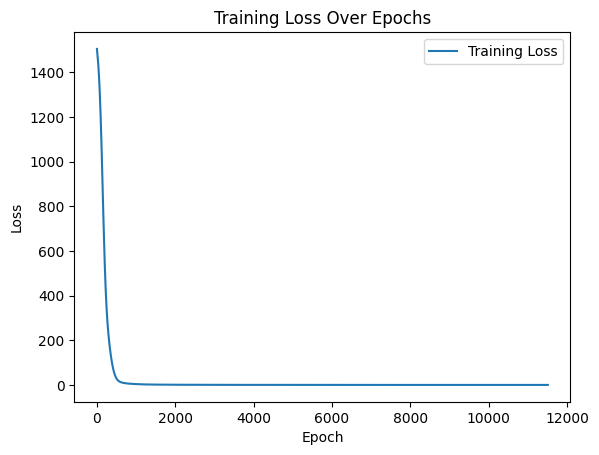

In [8]:
# Plotting
plt.plot(range(1, epoch + 2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

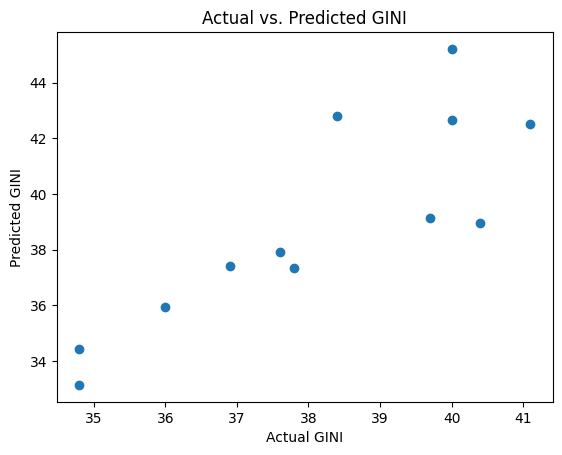

In [9]:

plt.scatter(y_test, predictions, alpha=1)
plt.xlabel('Actual GINI')
plt.ylabel('Predicted GINI')
plt.title('Actual vs. Predicted GINI')
plt.show()

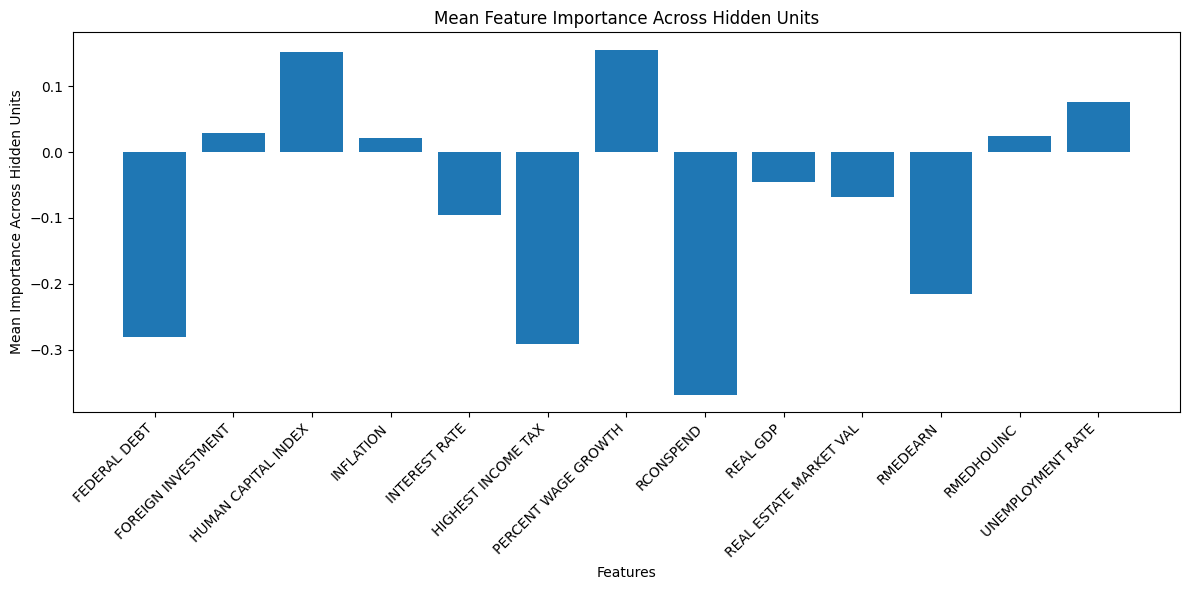

In [10]:
# Feature Importance Visualization:
weights_fc1 = model.fc1.weight.detach().numpy()

# Compute mean importance across hidden units for each feature
feature_importance_mean = weights_fc1.mean(axis=0)

plt.figure(figsize=(12, 6))

plt.bar(range(len(feature_importance_mean)), feature_importance_mean)
plt.xlabel('Features')
plt.ylabel('Mean Importance Across Hidden Units')
plt.title('Mean Feature Importance Across Hidden Units')
plt.xticks(range(len(features.columns)), features.columns, rotation=45, ha='right')

plt.tight_layout()
plt.show()

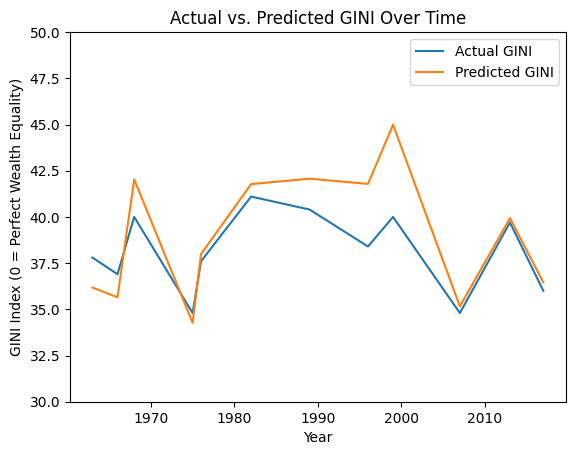

In [21]:
# Plotting time series data

y_test_sorted = y_test.sort_index()

plt.plot(y_test_sorted.index+START_YEAR, y_test, label='Actual GINI')
plt.plot(y_test_sorted.index+START_YEAR, predictions, label='Predicted GINI')
plt.xlabel('Year')
plt.ylabel('GINI Index (0 = Perfect Wealth Equality)')
plt.ylim(30,50)
plt.title('Actual vs. Predicted GINI Over Time')
plt.legend()
plt.show()

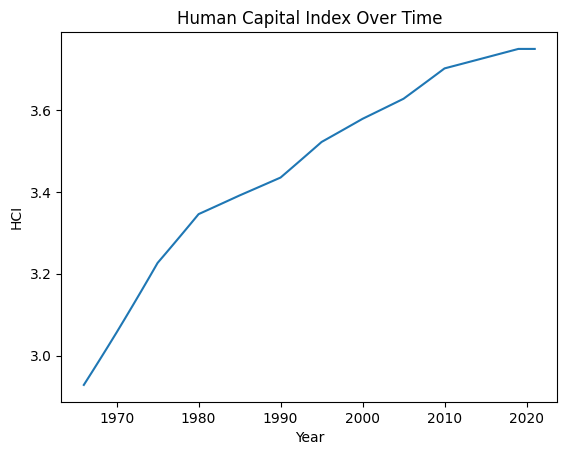

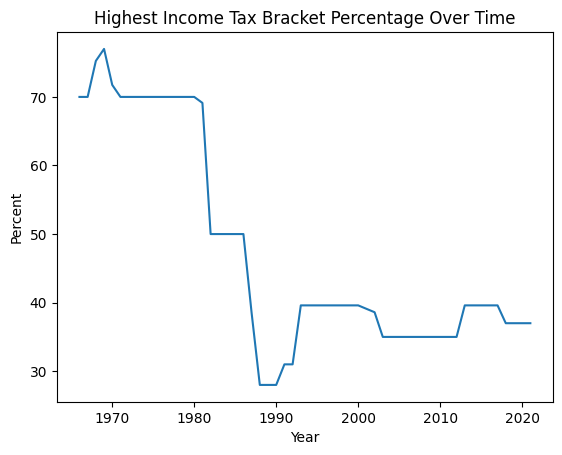

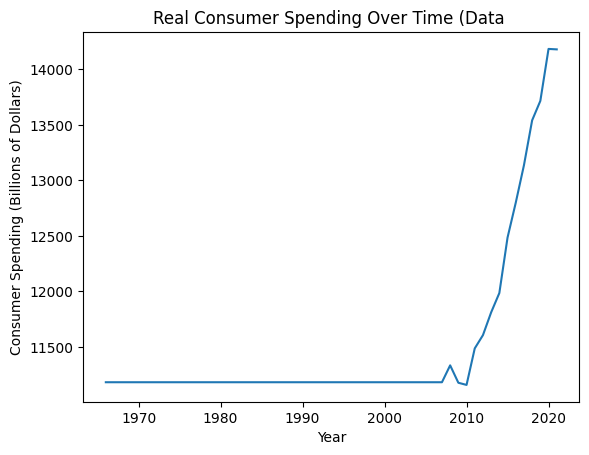

In [ ]:
#Interesting Feature Plots

# plt.plot(merged_df['YEAR'],merged_df['PERCENT WAGE GROWTH'])
# plt.xlabel('Year')
# plt.ylabel('Percent Wage Growth')
# plt.title('Percent Wage Growth Over Time')
# plt.show()

plt.plot(merged_df['YEAR'],merged_df['HUMAN CAPITAL INDEX'])
plt.xlabel('Year')
plt.ylabel('HCI')
plt.title('Human Capital Index Over Time')
plt.show()

plt.plot(merged_df['YEAR'],merged_df['HIGHEST INCOME TAX'])
plt.xlabel('Year')
plt.ylabel('Percent')
plt.title('Highest Income Tax Bracket Percentage Over Time')
plt.show()

plt.plot(merged_df['YEAR'],merged_df['RCONSPEND'])
plt.xlabel('Year')
plt.ylabel('Consumer Spending (Billions of Dollars)')
plt.title('Real Consumer Spending Over Time (Data ')
plt.show()
